<a href="https://colab.research.google.com/github/negbuna/models/blob/main/backtesting_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --quiet

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
sns.set_theme(style="darkgrid")
plt.style.use("dark_background")

[*********************100%***********************]  1 of 1 completed


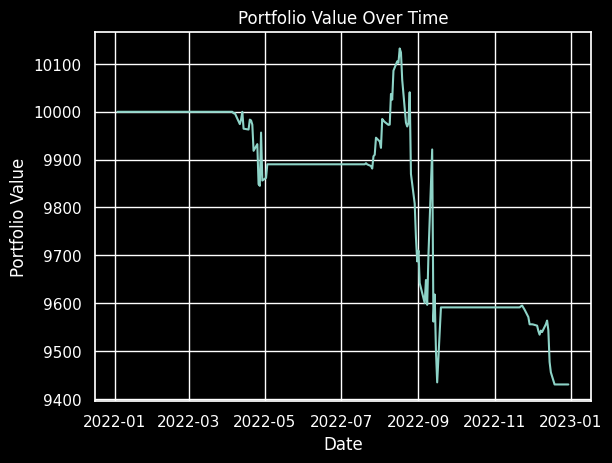

In [ ]:
df = yf.download("AAPL", start="2022-01-01", end="2023-01-01")
prices = df["Close"]
df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().apply(
    lambda x: x if x > 0 else 0).rolling(14).sum() / df['Close'].diff().apply(
        lambda x: abs(x) if x < 0 else 0
        ).rolling(14).sum()))
)

df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['Bollinger_Mid'] = df['Close'].rolling(20).mean()
df['Bollinger_Upper'] = df['Bollinger_Mid'] + 2 * df['Close'].rolling(20).std()
df['Bollinger_Lower'] = df['Bollinger_Mid'] - 2 * df['Close'].rolling(20).std()

def simple_moving_average_strategy(prices, short_window=20, long_window=50):
    short_ma = prices.rolling(short_window).mean()
    long_ma = prices.rolling(long_window).mean()
    signal = (short_ma > long_ma).astype(int)
    return signal

def run_backtest(prices, signals, initial_cash=10000):
    position = 0
    cash = initial_cash
    portfolio_value = []

    for price, signal in zip(prices.values, signals.values):
        if signal == 1 and cash >= price:
            position += 1
            cash -= price
        elif signal == 0 and position > 0:
            cash += price * position
            position = 0
        total_value = cash + position * price
        portfolio_value.append(total_value)

    return portfolio_value

signals = simple_moving_average_strategy(prices)
portfolio = run_backtest(prices, signals)

plt.plot(df.index, portfolio)
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()